# CNTK Word2Vec Part B - Learning and Visualizing Embeddings

We assume that you have successfully completed CNTK Word2Vec Part A.

In this tutorial we will learn word embeddings using **Skip Gram** model of **Word2Vec**.

## Introduction

**Problem** (recap from the CNTK Word2Vec Part A):

To learn a rich vector space representation for words where similar words occur together.

**Approach**:
As discussed in various other CNTK Tutorials, there are 5 stages in tackling any machine learning task: Data reading, Data preprocessing, Creating a model, Learning the model parameters and Evaluating (a.k.a. testing/prediction) the model. 
- Data reading: Will load the data from the pickle file saved in part A.
- Data preprocessing: Covered in part A. 

Rest of the steps will be covered here. 

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import pickle
import random
import sys

import numpy as np
from cntk.initializer import uniform
from cntk.learner import learning_rate_schedule, sgd, UnitType
from cntk.ops import *
from cntk.trainer import Trainer
from cntk.utils import ProgressPrinter

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

%matplotlib inline


curr_epoch = 0
emb_size = 256
minibatch_size = 256
num_epochs = 2
skip_window = 1
vocab_size = 4096
words_per_epoch = 4096
words_seen = 0
words_to_train = 1024


data = list()
embeddings = None


dictpickle = 'w2v-dict.pkl'
datapickle = 'w2v-data.pkl'
embpickle = 'w2v-emb.pkl'

# Ensure we always get the same amount of randomness
np.random.seed(0)

## Defining the Model

In skip gram model, we give the embeddings of the target word as input to a system and it will predict the context words around the target word. Example, for the sentence, 

                               the quick brown fox jumped over the lazy dog

Some example *(input, target)* pairs would be: *(fox, brown)* and *(fox, quick)* for a context window of size 1.

We can consider this task as a **multi-class classification problem** and model it using **logistic regression**. The input dimension is the embedding size and number of output classes is equal to vocalbulary size as each word can be considered as a class. <br \> <br \>
We then pass the output distribution through a **softmax layer** to convert it into a **probability distribution** and interpret it as, given the input embeddings which *classes* (read *words*) have a high probability of occuring in its context. During the training phase, we supply as the target, a **one-hot** representation of size equal to vocabulary size.

In [2]:
def lrmodel(inp, out_dim):
    inp_dim = inp.shape[0]
    wt = parameter(shape=(inp_dim, out_dim), init=uniform(scale=1.0))
    b = parameter(shape=(out_dim), init=uniform(scale=1.0))
    out = times(inp, wt) + b
    return out

## Defining the Trainer

In this section, we will define the *parameters*, the *loss function* and *optimization procedure*.

Since, our system has to **learn the embeddings** from experience, hence it must be present as a parameter to out model and later passed on in the parameter list to the optimizer. The shape would be, *(vocabulary_size x embedding_size)*

    Input: One-hot representation (dimension equals vocabulary size) of the 'input word'.
    Target: One-hot representation (dimension equals vocabulary size) of the 'target labels'.

We use a global variable to point to our embeddings parameter, so that during training we can evaluate it in between.

### Getting the input word's Embeddings
Compute the vector-matrix multipication between the input and the embeddings matrix, to get the embedding vector for the input word. Then we pass it to the logistic regression model and pass the outputs through a softmax layer. 

### Loss Computation
For a good word embedding, we would want P (probability),
    
    P(target context word) : high
    P(other words) : low

Using this logic, for output vector **o** and target vector **t**, vocabulary size *n*,  

$$loss(\textbf{o}, \textbf{t}) = - \sum_{i = 1}^n t_i log(o_i) - \sum_{i = 1}^n \frac{(1 - t_i)}{(n - 1)} log(1 - o_i) $$

We know that target vector **t** is one-hot, to make **(1-t)** also a probability distribution, we divide by, *(n-1)*, to make sum of elements equal 1 (one).

### Evaluation Error and Fixing Learning Rate Schedule
Then, we define the error to report for evaluating our model and define the learning rate schedule. Note, we decrease the learning rate with mini-batches because, as our model gets more and more experience, it learns the parameters approximately and furthur training is for fine tuning these parameters.

Then, pass the training parameters, loss and error functions to the *Stocastic Gradient Descent* Optimizer.

Note, in all, here we have 3 paramters to learn:

1. Weight matrix for Logistic Regression

2. Bias vector for Logistic Regression

3. The overall embeddings matrix


In [3]:
def train(emb_size, vocab_size):
    global embeddings, words_to_train

    inp = input_variable(shape=(vocab_size,))
    label = input_variable(shape=(vocab_size,))

    init_width = 0.5 / emb_size
    emb = parameter(shape=(vocab_size, emb_size), init=uniform(scale=init_width))
    embeddings = emb
    embinp = times(inp, emb)

    z = softmax(lrmodel(embinp, vocab_size))        # logistic regression model

    loss = - label * log(z) - ((1 - label) / (vocab_size - 1)) * log(1 - z)
    eval_error = classification_error(z, label)

    lr_per_sample = [0.003]*4 + [0.0015]*24 + [0.0003]
    lr_per_minibatch = [x * minibatch_size for x in lr_per_sample]
    lr_schedule = learning_rate_schedule(lr_per_minibatch, UnitType.minibatch)
    
    learner = sgd(z.parameters, lr=lr_schedule)
    trainer = Trainer(z, loss, eval_error, learner)

    return inp, label, trainer

## Building the Dataset

In this section, we will load the processed data from CNTK Word2Vec Part A.

In [4]:
def build_dataset():
    global data, num_epochs, words_per_epoch, words_to_train
    with open(datapickle, 'rb') as handle:
        data = pickle.load(handle)
    words_per_epoch = len(data)
    words_to_train = num_epochs * words_per_epoch

## Generating Mini-Batches of Data

In this section, we generate mini-batches of data from our processed corpus, to be fed to the system for learning.

In [5]:
def generate_batch(batch_size, skip_window):
    """ Function to generate a training batch for the skip-gram model. """
    
    global data, curr_epoch, words_per_epoch, words_seen
    
    data_index = words_seen - curr_epoch * words_per_epoch
    num_skips = 2 * skip_window
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    
    batch = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    buffer = collections.deque(maxlen=span)
    
    for _ in range(span):
        buffer.append(data[data_index])
        words_seen += 1
        data_index += 1
        if data_index >= len(data):
            curr_epoch += 1
            data_index -= len(data)
    
    for i in range(batch_size // num_skips):
        target = skip_window    # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            
            targets_to_avoid.append(target)
            batch[i * num_skips + j, 0] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        
        buffer.append(data[data_index])
        words_seen += 1
        data_index += 1
        if data_index >= len(data):
            curr_epoch += 1
            data_index -= len(data)
    
    return batch, labels

## Creating One-Hot Vectors

In [6]:
def get_one_hot(origlabels):
    global minibatch_size, vocab_size
    labels = np.zeros(shape=(minibatch_size, vocab_size), dtype=np.float32)
    for t in range(len(origlabels)):
        if origlabels[t, 0] < vocab_size and origlabels[t, 0] >= 0:
            labels[t, origlabels[t, 0]] = 1.0
    return labels

## Training and Testing

Note: For *full* training, the below code may take many hours to complete.

In [ ]:
build_dataset()

inp, label, trainer = train(emb_size, vocab_size)
print('Model Creation Done.')
pp = ProgressPrinter(50)
for _epoch in range(num_epochs):
    i = 0
    while curr_epoch == _epoch:
        features, labels = generate_batch(minibatch_size, skip_window)
        features = get_one_hot(features)
        labels = get_one_hot(labels)
        
        trainer.train_minibatch({inp: features, label: labels})
        pp.update_with_trainer(trainer)
        i += 1
        if i % 200 == 0:
            print('Saving Embeddings..')
            with open(embpickle, 'wb') as handle:
                pickle.dump(embeddings.value, handle)

    pp.epoch_summary()

test_features, test_labels = generate_batch(minibatch_size, skip_window)
test_features = get_one_hot(test_features)
test_labels = get_one_hot(test_labels)

avg_error = trainer.test_minibatch({inp: test_features, label: test_labels})
print('Avg. Error on Test Set: ', avg_error)

Model Creation Done.
 Minibatch[   1-  50]: loss = 8.152548 * 12800
 Minibatch[  51- 100]: loss = 7.925142 * 12800
 Minibatch[ 101- 150]: loss = 7.568645 * 12800
 Minibatch[ 151- 200]: loss = 7.468615 * 12800
Saving Embeddings..
 Minibatch[ 201- 250]: loss = 7.480372 * 12800
 Minibatch[ 251- 300]: loss = 7.402121 * 12800
 Minibatch[ 301- 350]: loss = 7.360544 * 12800
 Minibatch[ 351- 400]: loss = 6.831184 * 12800
Saving Embeddings..
 Minibatch[ 401- 450]: loss = 6.755818 * 12800
 Minibatch[ 451- 500]: loss = 6.736841 * 12800


## Visualizing the Embeddings

Now, that we have learnt the embeddings, its time to graphically evaluate how good they are. Since, the embedding dimensions are much more than 2 or 3 dimensions, it is not possible to plot them as they are. We need to reduce their dimensions and in the process also retain maximum amount of valuable information. 

Hence, we use the method of [t-SNE](https://lvdmaaten.github.io/tsne/) projections, to project them onto 2 dimensions by reducing dimensions using [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis).

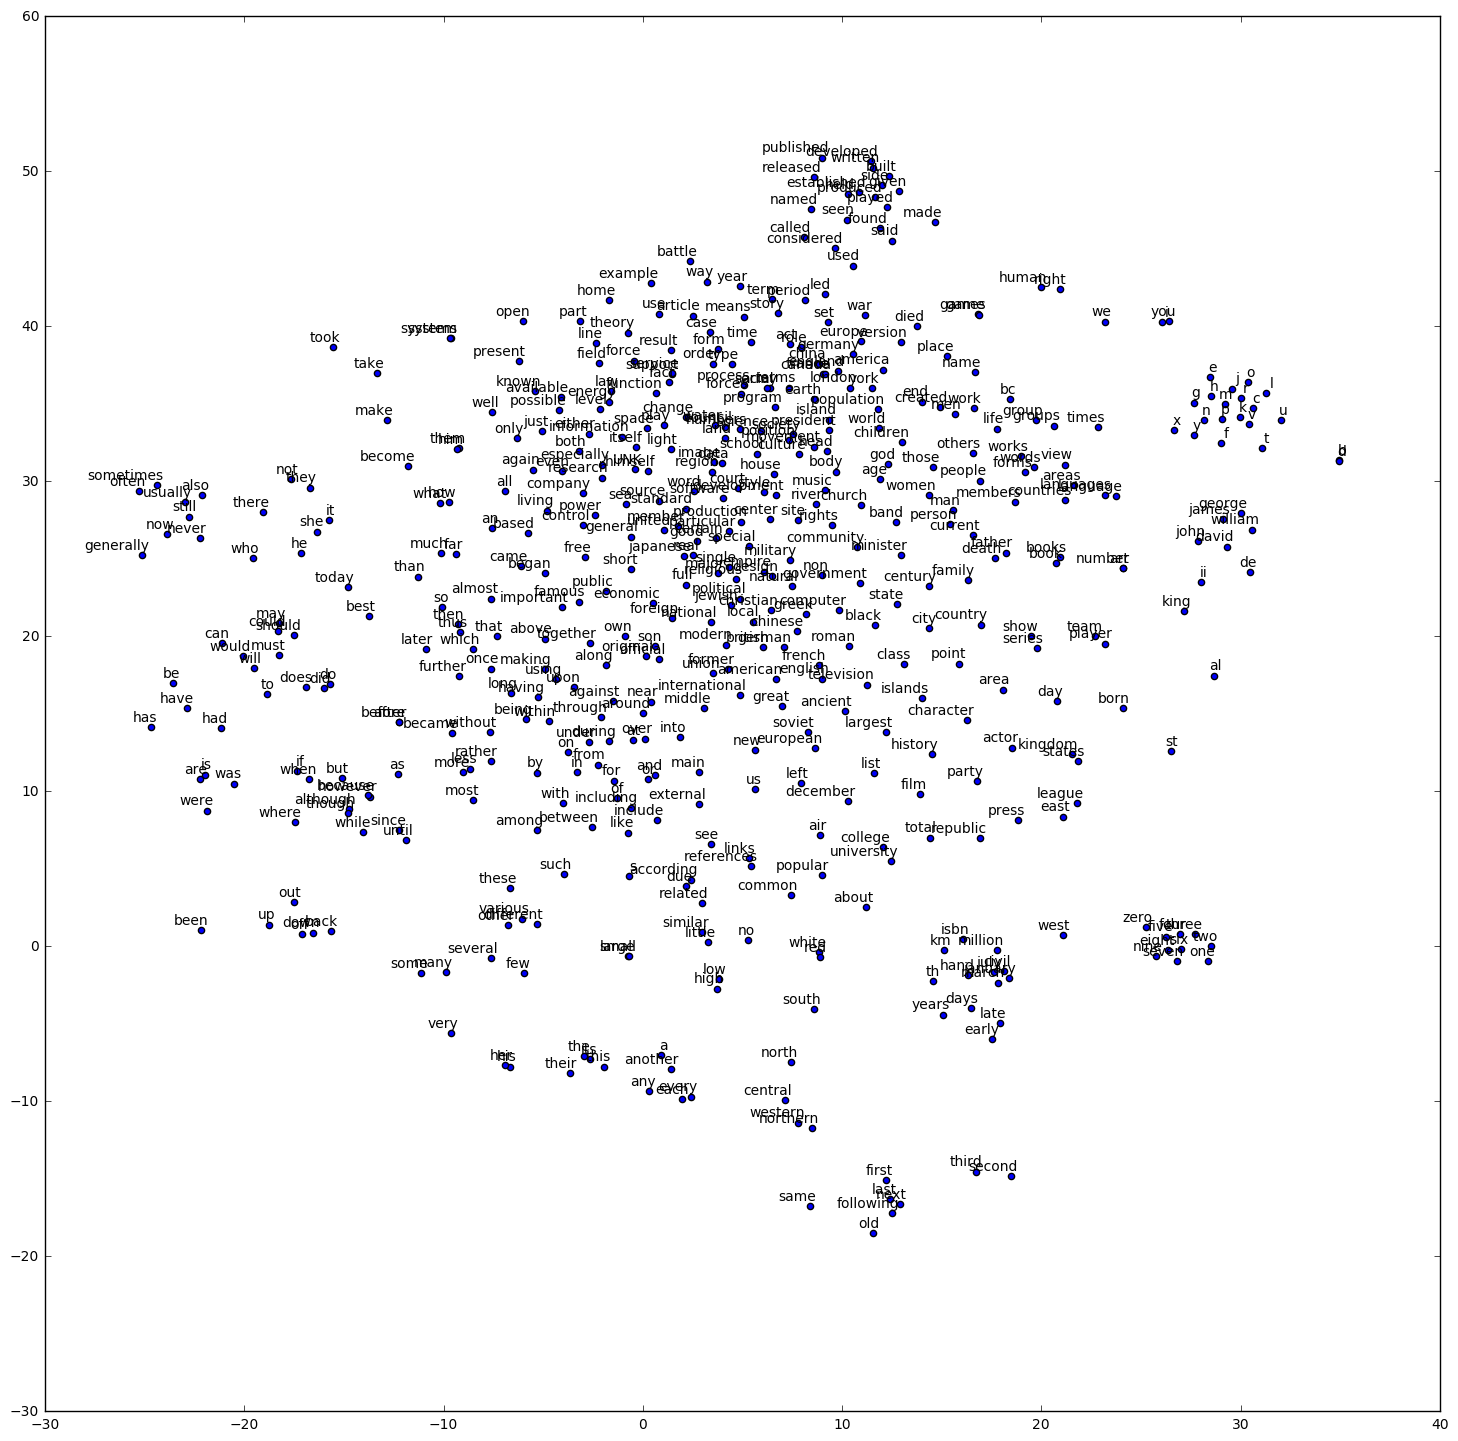

In [2]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()


tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
with open(embpickle, 'rb') as handle:
    final_embeddings = pickle.load(handle)

low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])

with open(dictpickle, 'rb') as handle:
    dictionary = pickle.load(handle)
reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

### Exploration Suggestion

1. Try exploring how the system behaves with different parameters like,
      a. Changing the minibatch size
      b. Changing the embeddings dimension. Which embedding size seems to work the best? <br \> <br \>

2. **Negative Sampling**: Recall, in the loss function, we include probability of not predicting words other than the target words, P(other words). Even in the logistic regression model, the output side has dimensions equal to vocabulary size. This can be huge and to train the model well (and avoid **overfitting**), the model has to crunch in large amount of data. <br \> <br \>So, we can reduce the complexity of the system, by using Negative Sampling. Using negative sampling, we say, that instead of picking all words in the dictionary, pick up say 100 words from their **unigram probability distribution** and only compute the loss based on these 100 words. In practice, this has been seen to work as a good approximation. More details can be found [here](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). I am currently working on this, will add to the tutorial as soon as its ready.

### Running from Command Prompt

If you want to try running the tutorial from python command prompt. Please run python files present in the repository.

## References

1. [CNTK Python API Documentation](https://cntk.ai/pythondocs) <br \>
2. [CNTK Python Tutorials](https://github.com/Microsoft/CNTK/tree/master/Tutorials) <br \>
3. [Tensorflow Word2Vec](https://www.tensorflow.org/versions/r0.11/tutorials/word2vec) <br \>